In [1]:
import sys
from pyprojroot import here

sys.path.append(str(here()))

# RBIG Packages
from rbig.data import ToyData
from rbig.layers import RBIGLayer
from rbig.models import GaussianizationModel
# import RBIG Layer
from rbig.layers.rbig_layer import RBIGLayer
from rbig.transform.gaussianization import MarginalGaussianization
from rbig.transform.uniformization import KDEUniformization, HistogramUniformization
from rbig.transform.linear import OrthogonalTransform
from rbig.transform.marginal import MarginalTransformation
from rbig.transform.gaussianization import Gaussianization
from rbig.stopping import MaxLayers, InfoLoss
from typing import Iterable, Optional, Dict, NamedTuple, Tuple, Union
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np
from scipy import stats

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(["seaborn-paper"])

%load_ext autoreload
%autoreload 2

## Data

<Figure size 360x360 with 0 Axes>

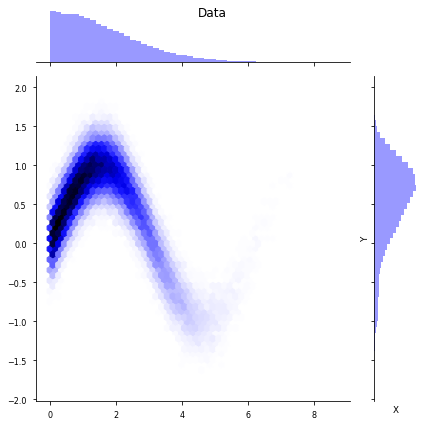

In [24]:
def plot_2d_joint(data, color='blue', title='Original Data'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs, title='Probabilities'):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap='Reds')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    ax.set_title(title)
    plt.show()
    
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'rbig'
n_samples = 100_000
n_features = 2
noise = 0.25
random_state=1
clusters = 2


data = ToyData(
    dataset=dataset, 
    n_samples=n_samples, 
    n_features=n_features, 
    noise=noise, 
    random_state=random_state,
    clusters=clusters,
).generate_samples()

plot_2d_joint(data, title='Data')

## Options

RBIG 1.1 - "Stopping"
* Max # of layers
* Information Loss
* Negative Log Likelihood
* Non-Gaussianity (?)
* Difference in Non-Gaussianity? (norm(y) - norm(x) - log abs( dy/dx))

RBIG 2.0 - "Loss"
* Negative Log Likelihood
* Non-Gaussianity (?)

RBIG 2.0 - **Stopping**: 
* Max Layers (epochs)
* Information Loss(Xtrans, X)
* Difference in Non-Gaussianity? (norm(y) - norm(x) - log abs( dy/dx))

## Loss Function I - Maximum # layers

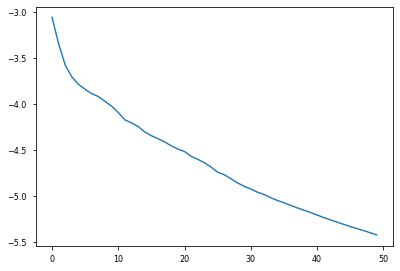

<Figure size 360x360 with 0 Axes>

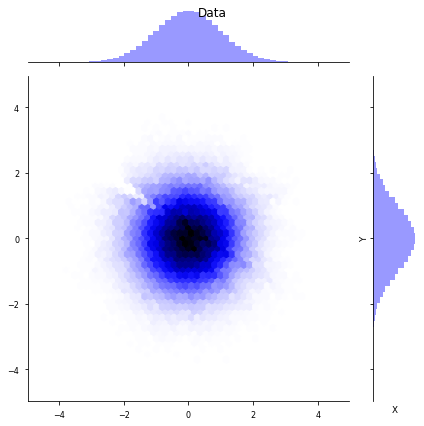

In [25]:
# Step 1 - Pick a Uniformization Transformer
uniform_clf = HistogramUniformization(bins=100, support_extension=10, alpha=1e-4, n_quantiles=None)
# uniform_clf = KDEUniformization(n_quantiles=50, method='fft', )
# Step 1 - Pick a Uniformization Transformer
# uniform_clf = HistogramUniformization(bins=100, support_extension=10, alpha=1e-4, n_quantiles=None)
# uniform_clf = KDEUniformization(n_quantiles=50, method='fft', )
gauss_transformer = Gaussianization(uniform_clf)
# Step 2 - Initialize Marginal Gaussianization Transformer
mg_gaussianization = MarginalTransformation(gauss_transformer)


# Step 3 - Pick Rotation transformer
orth_transform = OrthogonalTransform('pca')

# Step 4 - Initialize RBIG Block
rbig_block = RBIGLayer(mg_gaussianization, orth_transform)

# initialize rbig model
rbig_loss = MaxLayers(n_layers=50)

rbig_model = GaussianizationModel(rbig_block, rbig_loss)

# transform data to latent space
Z, _ = rbig_model.fit_transform(data)

# plot loss
plt.plot(rbig_model.losses_)
plot_2d_joint(Z, title='Data')

### Loss Function I.I - Custom Loss Function

In [5]:
def negative_log_likelihood(Z, X, X_slogdet):
    
    # calculate the log probability in latent space
    Z_logprob = stats.norm().logpdf(Z)
    
    # calculate the probability of the transform
    X_logprob = Z_logprob.sum(axis=1) + X_slogdet.sum(axis=1)
    
    # return the nll
    return np.mean(X_logprob)

def difference_nongaussian(Z, X, X_slogdet):
    
    delta_ng = .5 * np.linalg.norm(Z, 2)**2 - .5 * np.linalg.norm(X, 2)**2 - X_slogdet.sum(axis=1)
    
    return np.mean(delta_ng)

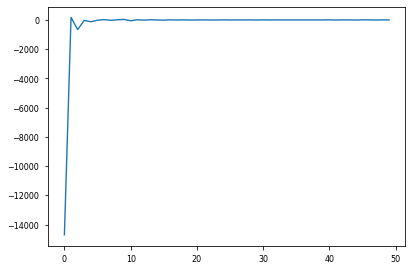

<Figure size 360x360 with 0 Axes>

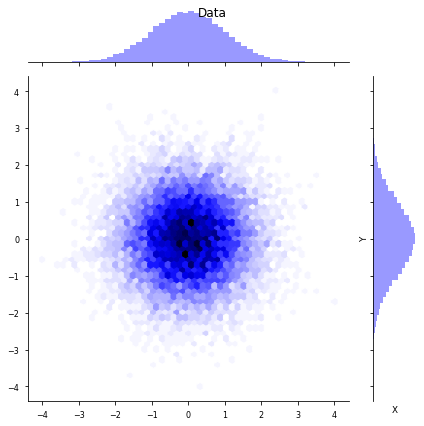

In [6]:
# initialize params
rbig_params = RBIGParams()

# initialize rbig model
rbig_loss = MaxLayersLoss(n_layers=50, loss_func=difference_nongaussian)

rbig_model = GaussianizationModel(rbig_params, rbig_loss)

# transform data to latent space
Z, _ = rbig_model.fit_transform(data)

# plot loss
plt.plot(rbig_model.losses_)
plot_2d_joint(Z, title='Data')

## Loss II - Information Reduction

In [ ]:
# Step 1 - Pick a Uniformization Transformer
# uniform_clf = HistogramUniformization(bins=100, support_extension=10, alpha=1e-4, n_quantiles=None)
uniform_clf = KDEUniformization(n_quantiles=50, method='knn', )
# Step 1 - Pick a Uniformization Transformer
# uniform_clf = HistogramUniformization(bins=100, support_extension=10, alpha=1e-4, n_quantiles=None)
# uniform_clf = KDEUniformization(n_quantiles=50, method='fft', )
gauss_transformer = Gaussianization(uniform_clf)
# Step 2 - Initialize Marginal Gaussianization Transformer
mg_gaussianization = MarginalTransformation(gauss_transformer)


# Step 3 - Pick Rotation transformer
orth_transform = OrthogonalTransform('pca')

# Step 4 - Initialize RBIG Block
rbig_block = RBIGLayer(mg_gaussianization, orth_transform)

# initialize rbig model
rbig_loss = InfoLoss(tol_layers=50)

rbig_model = GaussianizationModel(rbig_block, rbig_loss)

# transform data to latent space
Z, _ = rbig_model.fit_transform(data)

# plot loss
plt.plot(rbig_model.losses_)
plot_2d_joint(Z, title='Data')

In [ ]:
plt.plot(np.cumsum(rbig_model.losses_))
print("Total Correlation:", np.sum(rbig_model.losses_))

### Difference in Entropy Estimators

In [22]:
for estimator in ['kde', 'histogram', 'knn', 'gauss']:
    H_delta = InfoLoss(method=estimator).calculate_loss(Z, data)
    print(f"Estimator: {estimator}\nDelta H: {H_delta:.4f}",)

Estimator: kde
Delta H: 0.6107
Estimator: histogram
Delta H: 0.6829
Estimator: knn
Delta H: 0.6856
Estimator: gauss
Delta H: 0.8109


### Speed of Entropy Estimators

In [23]:
%timeit _ = InfoLoss(method='kde').calculate_loss(Z, data)
%timeit _ = InfoLoss(method='knn').calculate_loss(Z, data)
%timeit _ = InfoLoss(method='histogram').calculate_loss(Z, data)
%timeit _ = InfoLoss(method='gauss').calculate_loss(Z, data)

846 ms ± 6.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
64 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.19 ms ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.1 ms ± 4.25 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Loss III - Neg Entropy

In [19]:
from rbig.losses import NegEntropyLoss

In [22]:
# initialize params
rbig_params = RBIGParams()

# initialize rbig model
rbig_loss = NegEntropyLoss(tol_layers=50)
# rbig_loss = NegEntropyLoss(tol_layers=10)

rbig_model = GaussianizationModel(rbig_params, rbig_loss)

# transform data to latent space
Z, X_slogdet = rbig_model.fit_transform(data)

KeyboardInterrupt: 

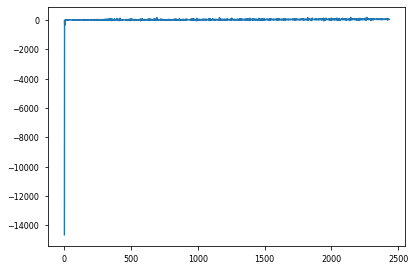

<Figure size 360x360 with 0 Axes>

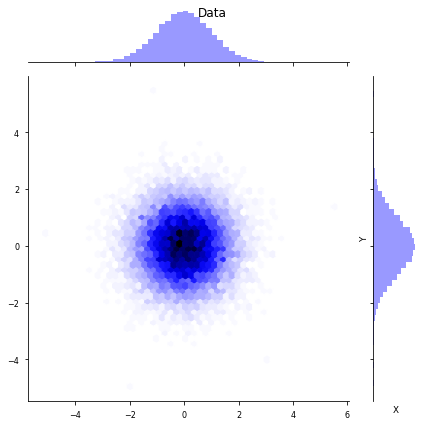

In [23]:
# plot loss
plt.plot(rbig_model.losses_)
plot_2d_joint(X_trans, title='Data')